In [1]:
import sys
sys.path.append("..")

In [2]:
# Imports
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import pandas as pd
from src.utils.image_utils import get_sample_image_size
from src.utils.csv_utils import split_classes
from src.utils.file_utils import train_test_split, num_images, create_dirs_if_not_exist
import torch.optim as optim
from tqdm.notebook import tqdm
import tempfile
import shutil

set computation device


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {device}")

Computation device: cpu


set hyper parameters


In [4]:
EPOCHS = 10
BATCH = 64

# percent of all data to go towards testing and validation
# TRACKS_PER_CLASS = 500
PERCENT_TESTING = 0.15
PERCENT_VALIDATION = 0.15
LEARNING_RATE = 0.001

# spectrogram parameters
RESOLUTION = 'low'
TRACK_DURATION = 15

# popularity thresholds
LOW_THRESHOLD = 500000
HIGH_THRESHOLD = 500000

#### load the train and test data


In [5]:
# Setting paths
dir_name = f"ch_{RESOLUTION}_{TRACK_DURATION}_all"
spectrograms_path = f"../data/spectrograms/{dir_name}"
print(f"Spectrograms path: {spectrograms_path}")
print(f"Number of spectrograms: {num_images(spectrograms_path)}")

# csv_path = f"..data/audio_features.csv"
csv_path = f"/Users/omersideman/dev/technion/ai-project/data/audio_features.csv"

df = pd.read_csv(csv_path)
print(f"Csv Length: {len(df)}")


# original_data = f"../data/spectrograms/{data_name}"
# data_dir = f"../data/organized_spectrograms/{data_name}"
# train_dir, test_dir = train_test_split(
#     original_data, data_dir, PERCENT_TESTING)

Spectrograms path: ../data/spectrograms/ch_low_15_all
Number of spectrograms: 3659
Csv Length: 3932


In [6]:
image_size = get_sample_image_size(spectrograms_path)
HEIGHT, WIDTH = image_size[0], image_size[1]
print(f"height: {image_size[0]}, width: {image_size[1]}")

Number of channels in the image: 1
height: 128, width: 162


In [7]:
def get_datasets(csv_path, spects_path, transform, low_th, high_th, PERCENT_TESTING):
    # create temporary folder to store spectrograms
    temp_dir = tempfile.mkdtemp(dir="../data/")

    # split into two classes based on popularity thresholds
    out_path = f"{temp_dir}/"
    split_classes(csv_path, spectrograms_path, out_path,
                  ['viral', 'notviral'], high_th, low_th)

    # copy spectrograms to temporary folder split into train and test directories
    data_dir = tempfile.mkdtemp(dir="../data/")
    train_dir, test_dir = train_test_split(temp_dir, data_dir, PERCENT_TESTING)
    train_dataset = ImageFolder(train_dir, transform=transform)
    test_dataset = ImageFolder(test_dir, transform=transform)

    # delete temporary folder
    shutil.rmtree(temp_dir)
    return train_dataset, test_dataset, data_dir

In [8]:
transform = transforms.Compose([
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_dataset, test_dataset, data_dir = get_datasets(
    csv_path, spectrograms_path, transform, LOW_THRESHOLD, HIGH_THRESHOLD, PERCENT_TESTING)

# dataset = ImageFolder(train_dir, transform=transform)
# test_dataset = ImageFolder(test_dir, transform=transform)

print(f"number of training images: {len(train_dataset)}")
print(f"number of testing images: {len(test_dataset)}")

cp: ../data/spectrograms/ch_low_15_all/1EcQvRklwuO1XAOgYaXkyz.png: No such file or directory
cp: ../data/spectrograms/ch_low_15_all/6RScVA1bXcmtXGD0wGyqXO.png: No such file or directory
cp: ../data/spectrograms/ch_low_15_all/6kx8Hf1Udk4V0Ivq6zpoyG.png: No such file or directory
cp: ../data/spectrograms/ch_low_15_all/4Ef75ndRbnsRvKEmNnLIyc.png: No such file or directory
cp: ../data/spectrograms/ch_low_15_all/30kXwHubMQ6NXloIz1NLbF.png: No such file or directory
cp: ../data/spectrograms/ch_low_15_all/0R1oBtQDX9N7ohedYIYbqT.png: No such file or directory
cp: ../data/spectrograms/ch_low_15_all/2wQjrEF5lHygwY0O5nfhEQ.png: No such file or directory
cp: ../data/spectrograms/ch_low_15_all/3ZKgX8g24IBomVqK7sqOst.png: No such file or directory
cp: ../data/spectrograms/ch_low_15_all/7n70tzvZDfdAL1j9XqsAbH.png: No such file or directory
cp: ../data/spectrograms/ch_low_15_all/11GTwrrhOACRiXnkaOSKjK.png: No such file or directory
cp: ../data/spectrograms/ch_low_15_all/38OXUB4FO1OD3Jbd2zqKzO.png: No 

Number of images per class: [2282, 1384]
Number of testing images per class: [342, 207]
Processing class: notviral
Created subdirectories: ../data/tmpj1izdbuc/training/notviral and ../data/tmpj1izdbuc/testing/notviral
Processing class: viral
Created subdirectories: ../data/tmpj1izdbuc/training/viral and ../data/tmpj1izdbuc/testing/viral
number of training images: 3117
number of testing images: 549


#### Looking at the dataset


In [21]:
img, label = train_dataset[0]
print(img.shape, label)
print("classes : \n", train_dataset.classes)

# num images per class
print("num images per class") 
print(train_dataset.targets.count(0))
print(train_dataset.targets.count(1))

FileNotFoundError: [Errno 2] No such file or directory: '../data/tmpj1izdbuc/training/notviral/003eoIwxETJujVWmNFMoZy.png'

display the first image in the dataset


Label : notviral


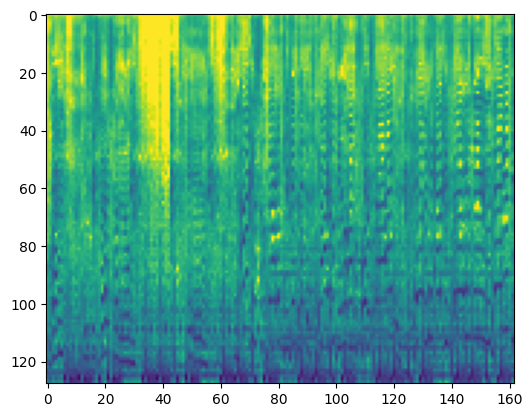

In [10]:
def display_img(img, label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1, 2, 0))


display_img(*train_dataset[0])

load the train and validation into batches.


In [11]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

val_size = int(len(train_dataset) * PERCENT_VALIDATION)
train_size = len(train_dataset) - val_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

# train_dl = DataLoader(train_data, BATCH, shuffle = True, num_workers = 4, pin_memory = True)
# val_dl = DataLoader(val_data, BATCH*2, num_workers = 4, pin_memory = True)

train_dl = DataLoader(train_data, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_data, batch_size=BATCH)
test_dl = DataLoader(test_dataset, batch_size=BATCH)

Length of Train Data : 2650
Length of Validation Data : 467


visualize a single batch of images


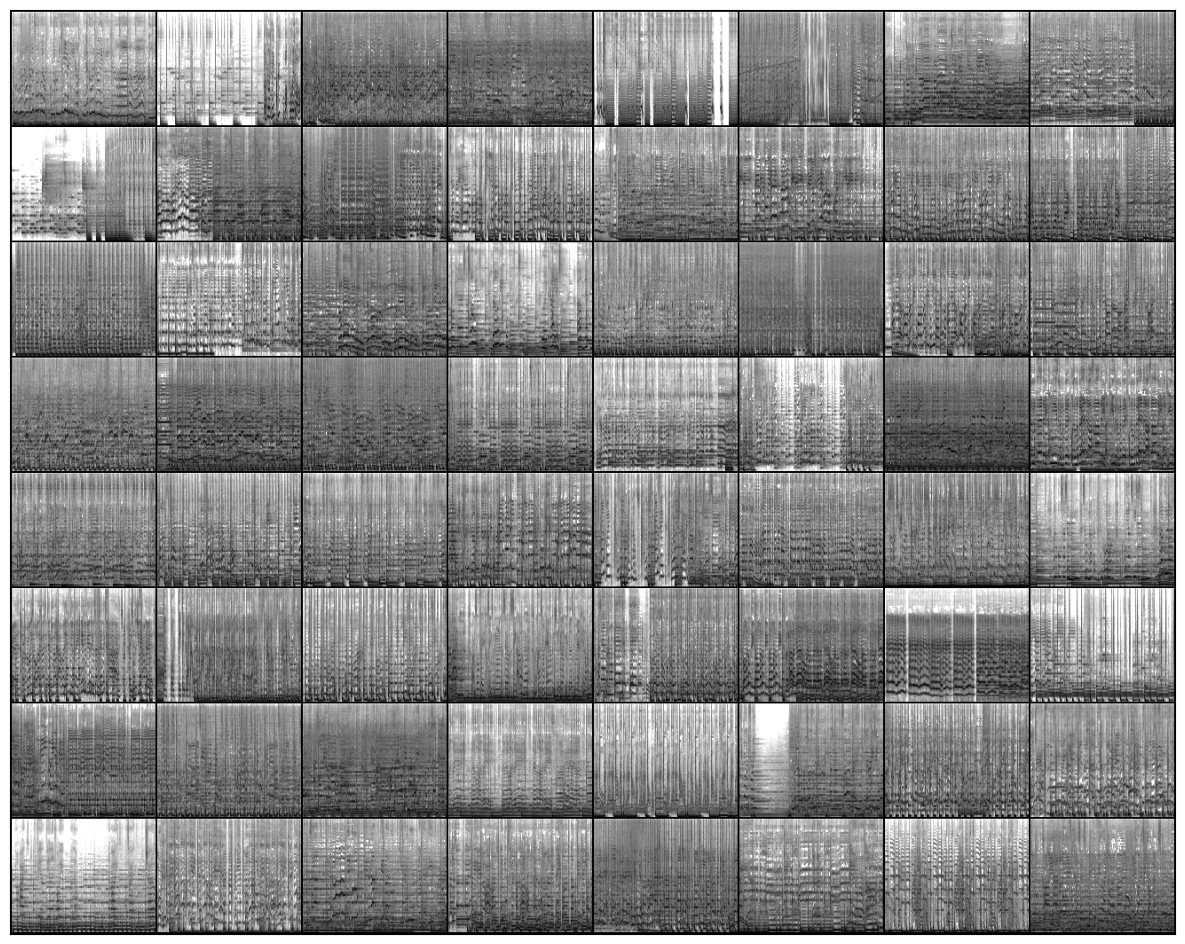

In [12]:
from torchvision.utils import make_grid


def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


show_batch(train_dl)

In [13]:
import torch.nn as nn


class VGG11(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        # convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Calculate the size of the feature maps after convolutional layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_output_size = self.calculate_conv_output_size(
            in_channels, WIDTH, HEIGHT
        )

        # fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=self.conv_output_size, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=self.num_classes),
        )

    def calculate_conv_output_size(self, in_channels, width, height):
        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, width, height)
            dummy_output = self.conv_layers(dummy_input)
            print(f"Dummy output shape: {dummy_output.shape}")
            return dummy_output.view(1, -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

Initialize model:


In [14]:
model = VGG11(in_channels=1, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

Dummy output shape: torch.Size([1, 512, 5, 4])


Function for training (one epoch)


In [15]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    cum_loss = 0.0
    cum_correct = 0

    for x, y in tqdm(trainloader, total=len(trainloader), desc="Training"):
        # print(x.shape, y.shape)
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        # print each label with corresponding prediction
        # for label, prediction in zip(y, pred):
        #     print(f'label: {label}, pred: {prediction}')

        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()
        cum_correct += (pred.argmax(1) == y).sum().item()

    epoch_acc = cum_correct / len(trainloader.dataset)
    epoch_loss = cum_loss / len(trainloader)
    return epoch_acc, epoch_loss

Function for testing (one epoch)


In [16]:
def test(model, testloader, criterion):
    model.eval()
    cum_loss = 0.0
    cum_correct = 0

    with torch.no_grad():
        for x, y in tqdm(testloader, total=len(testloader), desc="Testing"):
            (x, y) = (x.to(device), y.to(device))
            # print(x.shape, y.shape)
            pred = model(x)

            # print each blabel with corresponding prediction
            # for label, prediction in zip(y, pred):
            #     print(f'label: {label}, pred: {prediction}')

            # print(f"Labels: {y} pred: {pred}")
            loss = criterion(pred, y)
            cum_loss += loss
            cum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    epoch_acc = cum_correct / len(testloader.dataset)
    epoch_loss = cum_loss / len(testloader)
    return epoch_acc, epoch_loss

Training and testing the model:


In [17]:
# dictionary to keep track of losses and accuracies
H = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
}

# train the model
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_acc, train_epoch_loss = train(model, train_dl, optimizer, criterion)
    test_epoch_acc, test_epoch_loss = test(model, test_dl, criterion)
    # print all the metrics
    print(f"Train loss: {train_epoch_loss:.4f} | Train acc: {train_epoch_acc:.4f}")
    print(f"Test loss: {test_epoch_loss:.4f} | Test acc: {test_epoch_acc:.4f}")
    H["train_loss"].append(train_epoch_loss)
    H["train_acc"].append(train_epoch_acc)
    H["test_loss"].append(test_epoch_loss)
    H["test_acc"].append(test_epoch_acc)

Epoch 1 of 10


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Train loss: 0.6775 | Train acc: 0.5940
Test loss: 0.6776 | Test acc: 0.6230
Epoch 2 of 10


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Train loss: 0.6690 | Train acc: 0.6075
Test loss: 0.6759 | Test acc: 0.6230
Epoch 3 of 10


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Train loss: 0.6627 | Train acc: 0.6102
Test loss: 0.6755 | Test acc: 0.6193
Epoch 4 of 10


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Train loss: 0.6583 | Train acc: 0.6245
Test loss: 0.6760 | Test acc: 0.6211
Epoch 5 of 10


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Train loss: 0.6523 | Train acc: 0.6347
Test loss: 0.6788 | Test acc: 0.6248
Epoch 6 of 10


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Train loss: 0.6489 | Train acc: 0.6275
Test loss: 0.6767 | Test acc: 0.6138
Epoch 7 of 10


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Train loss: 0.6397 | Train acc: 0.6336
Test loss: 0.6782 | Test acc: 0.5993
Epoch 8 of 10


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Train loss: 0.6345 | Train acc: 0.6475
Test loss: 0.6786 | Test acc: 0.6066
Epoch 9 of 10


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Train loss: 0.6314 | Train acc: 0.6396
Test loss: 0.6849 | Test acc: 0.6211
Epoch 10 of 10


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Train loss: 0.6211 | Train acc: 0.6585
Test loss: 0.6791 | Test acc: 0.6193


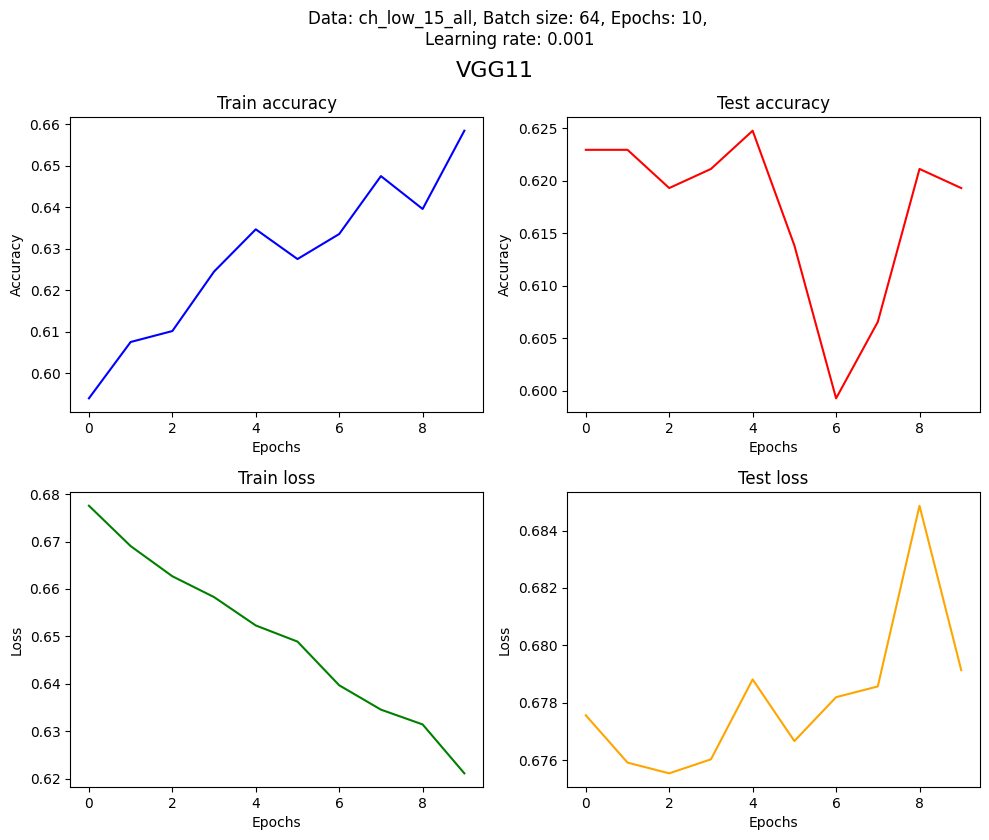

In [20]:
fig = plt.figure(figsize=(10, 8))
# supertitle
fig.suptitle("VGG11", fontsize=16)
info = f"""Data: {dir_name}, Batch size: {BATCH}, Epochs: {EPOCHS}, Learning rate: {LEARNING_RATE}
"""
fig.text(
    0.515, 1,info, ha='center', fontsize=12)


sub1 = fig.add_subplot(221)
sub1.set_title('Train accuracy')
sub1.plot(H["train_acc"], color='blue', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

sub2 = fig.add_subplot(222)
sub2.set_title('Test accuracy')
sub2.plot(H["test_acc"], color='red', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

sub3 = fig.add_subplot(223)
sub3.set_title('Train loss')
sub3.plot(H["train_loss"], color='green', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')


sub4 = fig.add_subplot(224)
sub4.set_title('Test loss')
sub4.plot([l.item() for l in H["test_loss"]], color='orange', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()